In [1]:
from src import cpp_soft_info

# Load Data

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from result_saver import SaverProvider
provider = SaverProvider()

In [37]:
import numpy as np
from Scratch import metadata_loader

DEVICE = 'ibm_sherbrooke'

md = metadata_loader(_extract=True, _drop_inutile=True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["notebook_name"] == "bigger_rep_codes"]
max_distance = int(max(md.distance))
max_distance = 20
md = md[md["distance"] == max_distance]
md = md[md["backend_name"]==DEVICE]

md = md[:2]

md

,creation_date,notebook_name,backend_name,job_id,tags,shots,tags_xp,rep_delay,sampled_state,num_qubits,job_status,extra,optimization_level,code,distance,rounds,logical,layout,descr
2568,2023-12-11 17:53:10.258000+01:00,bigger_rep_codes,ibm_sherbrooke,cnvkwxkvn4c0008a6b3g,[RepCode_Count_job],2500.0,NaN,NaN,NaN,NaN,JobStatus.DONE,NaN,NaN,RepetitionCodeCircuit,20.0,20,1,_is_hex=True,Run bigger Repetition codes v4: new distances ...
2567,2023-12-11 17:53:04.725000+01:00,bigger_rep_codes,ibm_sherbrooke,cnvkww3gpnkg008434rg,[RepCode_Count_job],2500.0,NaN,NaN,NaN,NaN,JobStatus.DONE,NaN,NaN,RepetitionCodeCircuit,20.0,20,0,_is_hex=True,Run bigger Repetition codes v4: new distances ...


In [38]:
memories = {}
jobs = {}
for job_id, logical in zip(md.job_id, md.logical):
    mmr_name = f"mmr_log_{logical}"
    memories[mmr_name] = provider.retrieve_job(job_id).result().get_counts()
    jobs[mmr_name] = job_id

memory_str = "mmr_log_0"
counts = memories[memory_str]
job_id = jobs[memory_str]
counts

{'10000000101000110000 1000000000100110000 0000000111000011000 1000000000100110000 0000000111000011000 1000000000000110000 0000001011100111000 1000000000001110000 0000001011100111000 1000000000001000000 0000001011100111000 1000000000001000000 0000001010100111000 1000000100100100000 0000001010100111000 1000000000100010000 0000001010100101000 0000000001100000000 0000000110000011000 0000000001100000000 0000000111000000000': 1,
 '11000000001110100010 0110011000001111010 0010011000000001001 0110011001011110010 1010011101000000010 0110001100111110010 0010000000000000011 0110001101100000010 0010000001000000010 0110000001000000010 0010000000100000010 0110000000000000010 1110000000100000010 1010000000000000010 1100000000100000010 1000000000000000010 1100000000000000010 1100000001100000010 1100000001100000010 1000001100100000010 0000000000100000000': 1,
 '01001010000100010110 0000011101000110111 0101100101010101010 0100001100100110111 0001101101110100110 0100000000100100011 0001101100010100110 0

# Initialize the code

#### Noise model stim

In [39]:
from datetime import datetime

def get_avgs_from_dict(noise_dict):
    '''
    Takes noise dictionary as an argument then returns length 5
    array defining average noise levels: [init, idle, RO, single-, two-qubit gate]
    '''
    init_avg = np.average([noise_dict[qubit]['init'] for qubit in noise_dict])
    idle_avg = np.average([noise_dict[qubit]['idle'] for qubit in noise_dict])
    RO_avg = np.average([noise_dict[qubit]['RO'] for qubit in noise_dict])
    single_avg = 1e-4#np.average([noise_dict[qubit]['init'] for qubit in noise_dict])
    two_gate_avg = np.average([noise_dict[qubit]['2-gate'][connection]
                        for qubit in noise_dict
                        for connection in noise_dict[qubit]['2-gate']
                        if connection != 'default'])
    return [init_avg, idle_avg, RO_avg, single_avg, two_gate_avg]
# End get_avgs_from_dict


def get_noise_dict_from_backend(backend, layout, date=None):
    '''
    Takes a given backend and a mapping object and returns a noise dictionary
    to pass to a new Cross_Platform_Code/Hex_Code to have accurate backend
    specific noise information based on calibration data.
    '''
    # Pre-reqs
    noise_dict = {}
    round_time = 1000e-9
    if date is None:
        t = None
    else:
        t = datetime(day=int(date[-2:]), month=int(date[-4:-2]), year=int(date[:4]))
    properties = backend.properties(datetime=t)
    # Initializing each qubit with single qubit noise
    for qubit in layout:
        # Defining ROI error
        ROI_error = properties.readout_error(qubit)
        # Defining idle error
        t1 = properties.t1(qubit)
        t2 = properties.t2(qubit)
        t_time = min(t1, t2)
        idle_error = 1 - np.exp(-round_time / t_time)
        # Updating dictionary
        noise_dict[qubit] = {}
        noise_dict[qubit]['init'] = ROI_error
        noise_dict[qubit]['idle'] = idle_error
        noise_dict[qubit]['RO'] = ROI_error
        noise_dict[qubit]['gate'] = 1e-4
        noise_dict[qubit]['2-gate'] = {'default': 1e-2}
    # Two qubit gate noise
    all_qiskit_indexes = layout 
    for pair in backend.coupling_map:
        # Making sure connection is in circuit
        if pair[0] in all_qiskit_indexes and pair[1] in all_qiskit_indexes:
            # Getting two qubit gate error
            two_gate_error = properties.gate_error('ecr', pair)
            if two_gate_error > .5:
                two_gate_error = .5
            # # Updating dictionary
            # stim_index_0 = map.get_stim_index(qiskit_index=pair[0])
            # stim_index_1 = map.get_stim_index(qiskit_index=pair[1])
            noise_dict[pair[0]]['2-gate'][pair[1]] = two_gate_error
            noise_dict[pair[1]]['2-gate'][pair[0]] = two_gate_error
    return noise_dict
# End get_noise_dict_from_backend

In [40]:

date = "2023-10-30 09:45:17.340386+01:00" #md.creation_date[0] # md[0] for log 1
noise_dict = get_noise_dict_from_backend(provider.get_backend(DEVICE), layout, date=other_date)
print("noise_dict:", noise_dict)
avgs_noise = get_avgs_from_dict(noise_dict)
print("avgs_noise [init_avg, idle_avg, RO_avg, single_avg, two_gate_avg]:", avgs_noise)

# takes 4s

noise_dict: {114: {'init': 0.012799999999999923, 'idle': 0.0036593906155806266, 'RO': 0.012799999999999923, 'gate': 0.0001, '2-gate': {'default': 0.01, 113: 0.005452106269309642, 115: 0.009751021836470197}}, 116: {'init': 0.00770000000000004, 'idle': 0.005675580168901018, 'RO': 0.00770000000000004, 'gate': 0.0001, '2-gate': {'default': 0.01, 115: 0.006665310149900822, 117: 0.01269433701778852}}, 118: {'init': 0.0040000000000000036, 'idle': 0.004544406240744481, 'RO': 0.0040000000000000036, 'gate': 0.0001, '2-gate': {'default': 0.01, 117: 0.005921658318412182, 119: 0.010853065924460586}}, 120: {'init': 0.010000000000000009, 'idle': 0.00352197246803454, 'RO': 0.010000000000000009, 'gate': 0.0001, '2-gate': {'default': 0.01, 119: 0.006469636251456773, 121: 0.005020561482665692}}, 122: {'init': 0.010199999999999987, 'idle': 0.0037506010734535966, 'RO': 0.010199999999999987, 'gate': 0.0001, '2-gate': {'default': 0.01, 121: 0.007181297829149641, 111: 0.010637920476153251}}, 104: {'init': 0.0

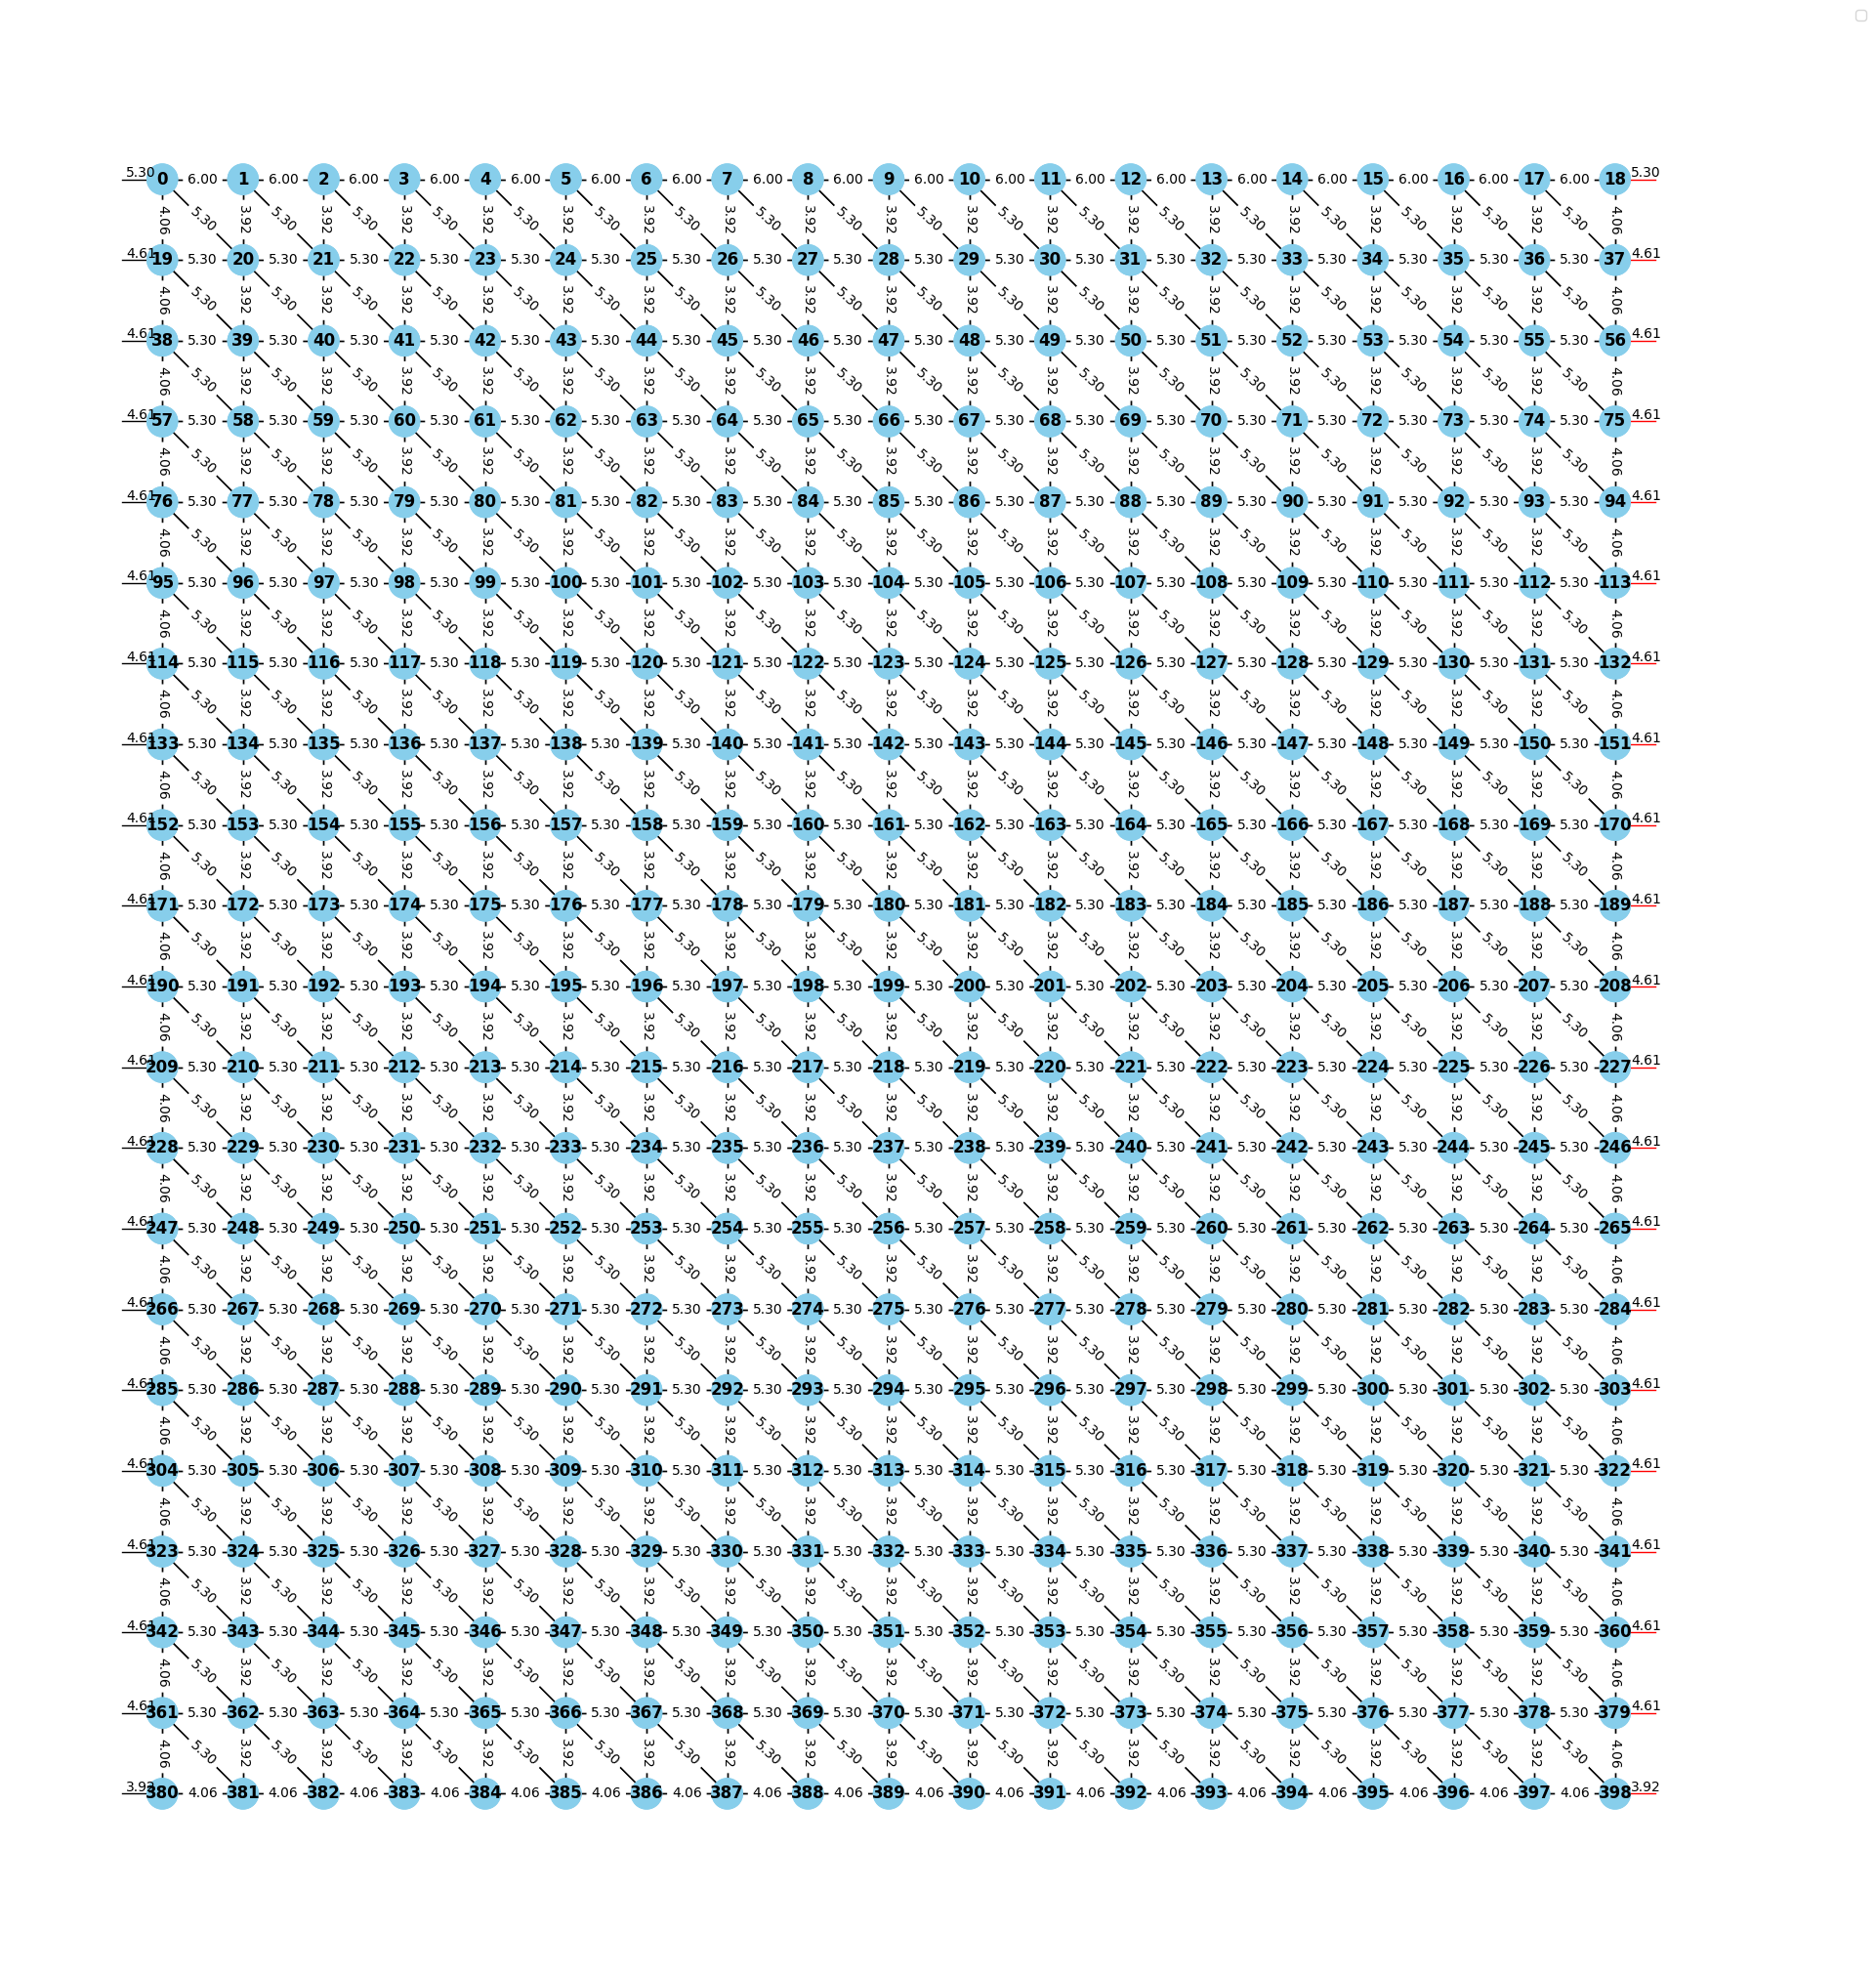

In [44]:
from soft_info import draw_matching_graph
import stim
import pymatching

d = max_distance
synd_rounds = d

circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=d,
                                rounds=synd_rounds,
                                after_clifford_depolarization= avgs_noise[4], #two-qubit-fidelity,
                                after_reset_flip_probability= 0, #reset error,
                                before_measure_flip_probability= avgs_noise[2], #measurement error,
                                before_round_data_depolarization= 0) #avgs_noise[1]) #idle error)
# print(circuit)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)
draw_matching_graph(matching, d, synd_rounds, figsize=(20, 20))   
# takes 10s

# Decode

In [45]:
from soft_info import counts_to_det_syndr
from tqdm import tqdm

num_errors = 0
for count_key, shots in tqdm(zip(counts.keys(), counts.values())):
    array_processed_string = counts_to_det_syndr(count_key, _resets=False, verbose=False)

    predicted_observables = matching.decode(array_processed_string)

    actual_observables = [(int(count_key[0])+0)%2]

    if actual_observables != predicted_observables:
        num_errors += shots

print(f"num_errors: {num_errors} out of {sum(counts.values())} shots")

2500it [00:00, 3692.48it/s]

num_errors: 6 out of 2500 shots
